# Import Package

In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128

transform = transforms.Compose([       # Ini adalah Pipeline 
    transforms.Grayscale(),            # bagian ini digunakan untuk merubah image yang berwarna menjadi hitamputih
    transforms.ToTensor()              # ini digunakan untuk Transform data yang berbentuk image menjadi Tensor
])

train_set = datasets.ImageFolder("data/data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)


test_set = datasets.ImageFolder("data/data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)


In [4]:
train_set # intip trains_set yang sudah di transform

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: data/data/train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [5]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

From the description above, the image has changed to a tensor

In [6]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Architecture & Config

In [7]:
from jcopdl.layers import linear_block

In [8]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(x)
        

Config adalah apapun yang mau kita save pada training kita

In [9]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

# Training Preparation -> MCOC

In [10]:
config.input_size

784

In [11]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss() 
optimizer = optim.AdamW(model.parameters(), lr=0.01) # Optimizer AdamW sudaha ada Regulerization sehingga bisa mengurangi Overfit
callback = Callback(model, config, outdir="model", early_stop_patience=1, plot_every=3)  # callback membantu kita save model(optimalnya early_stop_patience = 5)

# Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost /len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:01<?, ?it/s]

Test:   0%|          | 0/157 [00:01<?, ?it/s]


Epoch     1
Train_cost  = 0.7190 | Test_cost  = 0.4752 | Train_score = 0.7363 | Test_score = 0.8298 |


Train:   0%|          | 0/313 [00:01<?, ?it/s]

Test:   0%|          | 0/157 [00:01<?, ?it/s]


Epoch     2
Train_cost  = 0.5305 | Test_cost  = 0.4241 | Train_score = 0.8082 | Test_score = 0.8483 |


Train:   0%|          | 0/313 [00:01<?, ?it/s]

Test:   0%|          | 0/157 [00:01<?, ?it/s]


Epoch     3
Train_cost  = 0.4988 | Test_cost  = 0.4556 | Train_score = 0.8222 | Test_score = 0.8298 |


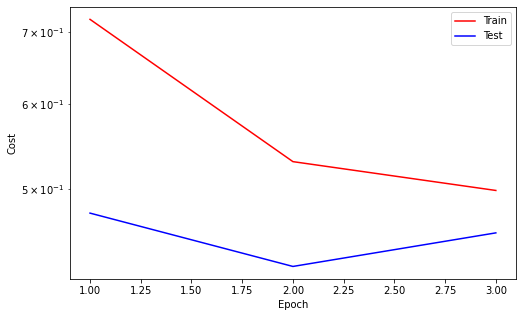

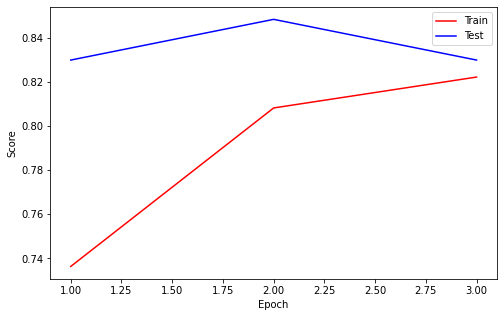

==> EarlyStop patience =  1 | Best test_score: 0.8483
==> Execute Early Stopping at epoch: 3 | Best test_score: 0.8483
==> Best model is saved at model


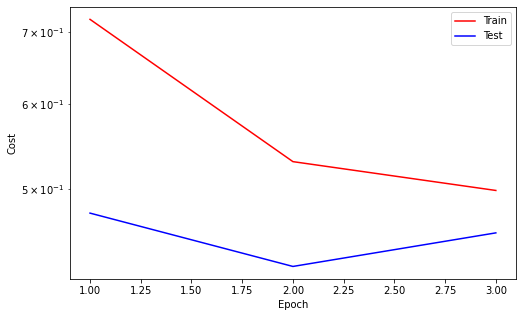

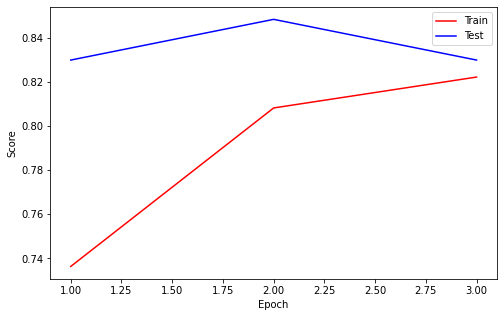

In [13]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint(ini cocok untuk training yang berat yang berminggu2 atau yang takut mati lampu ditengah jalan, jadi kalo bisa tiap berapa epoch ada save checkpoint) untuk safety
    callback.save_checkpoint()
    
    # sambil training sambil ngeplot
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [ ]:
# weights = torch.load('model/weights_best.pth', map_location='cpu')
# config = torch.load('model/configs.pth', map_location='cpu')

# model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
# model.load_state_dict(weights)
# model = model.to(device)

In [14]:
model

FashionClassifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=784, out_features=256, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (2): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=256, out_features=64, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (3): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=64, out_features=10, bias=True)
        (lsoftmax): LogSoftmax(dim=1)
      )
    )
  )
)

In [15]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [16]:
target

tensor([0, 8, 1, 3, 3, 1, 5, 8, 5, 9, 6, 6, 3, 9, 2, 7, 5, 7, 4, 3, 2, 8, 1, 4,
        2, 8, 7, 9, 8, 5, 6, 9, 3, 7, 8, 0, 9, 2, 1, 3, 3, 0, 8, 3, 7, 6, 8, 6,
        4, 0, 5, 3, 6, 9, 2, 5, 3, 6, 2, 9, 5, 3, 7, 3, 3, 5, 8, 3, 3, 9, 0, 9,
        7, 0, 6, 0, 0, 8, 8, 7, 0, 4, 7, 4, 1, 4, 0, 0, 7, 5, 1, 9, 5, 2, 0, 4,
        7, 8, 7, 2, 8, 3, 9, 4, 0, 2, 8, 3, 9, 0, 5, 6, 5, 6, 5, 5, 0, 7, 1, 1,
        7, 9, 4, 2, 6, 1, 3, 6])

In [17]:
with torch.no_grad():  # dihasilkan akurasi dengan weigths yang telah ditimpa dengan weights yang berasal dari Save Weights
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
print(preds)
[label2cat[pred] for pred in preds]

tensor([0, 1, 1, 6, 3, 1, 5, 8, 5, 9, 6, 4, 3, 9, 2, 7, 5, 7, 4, 3, 2, 8, 1, 4,
        2, 8, 7, 9, 8, 5, 6, 9, 3, 5, 1, 0, 9, 6, 1, 3, 3, 0, 8, 3, 7, 4, 8, 6,
        4, 0, 5, 3, 6, 9, 2, 5, 3, 6, 2, 9, 5, 3, 7, 3, 8, 5, 8, 2, 3, 9, 5, 9,
        7, 5, 6, 0, 0, 8, 8, 7, 0, 4, 7, 4, 1, 4, 0, 0, 7, 5, 1, 9, 5, 2, 0, 4,
        7, 6, 7, 3, 8, 3, 9, 4, 0, 2, 8, 3, 9, 0, 5, 6, 5, 6, 5, 5, 0, 7, 1, 1,
        7, 9, 6, 4, 6, 1, 3, 6])


['Ankle boot',
 'Bag',
 'Bag',
 'Shirt',
 'Dress',
 'Bag',
 'Sandal',
 'T-shirt or Top',
 'Sandal',
 'Trouser',
 'Shirt',
 'Pullover',
 'Dress',
 'Trouser',
 'Coat',
 'Sneaker',
 'Sandal',
 'Sneaker',
 'Pullover',
 'Dress',
 'Coat',
 'T-shirt or Top',
 'Bag',
 'Pullover',
 'Coat',
 'T-shirt or Top',
 'Sneaker',
 'Trouser',
 'T-shirt or Top',
 'Sandal',
 'Shirt',
 'Trouser',
 'Dress',
 'Sandal',
 'Bag',
 'Ankle boot',
 'Trouser',
 'Shirt',
 'Bag',
 'Dress',
 'Dress',
 'Ankle boot',
 'T-shirt or Top',
 'Dress',
 'Sneaker',
 'Pullover',
 'T-shirt or Top',
 'Shirt',
 'Pullover',
 'Ankle boot',
 'Sandal',
 'Dress',
 'Shirt',
 'Trouser',
 'Coat',
 'Sandal',
 'Dress',
 'Shirt',
 'Coat',
 'Trouser',
 'Sandal',
 'Dress',
 'Sneaker',
 'Dress',
 'T-shirt or Top',
 'Sandal',
 'T-shirt or Top',
 'Coat',
 'Dress',
 'Trouser',
 'Sandal',
 'Trouser',
 'Sneaker',
 'Sandal',
 'Shirt',
 'Ankle boot',
 'Ankle boot',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sneaker',
 'Ankle boot',
 'Pullover',
 'Sneaker',


# Try Predicting Results with Visualization

In [18]:
import matplotlib.pyplot as plt

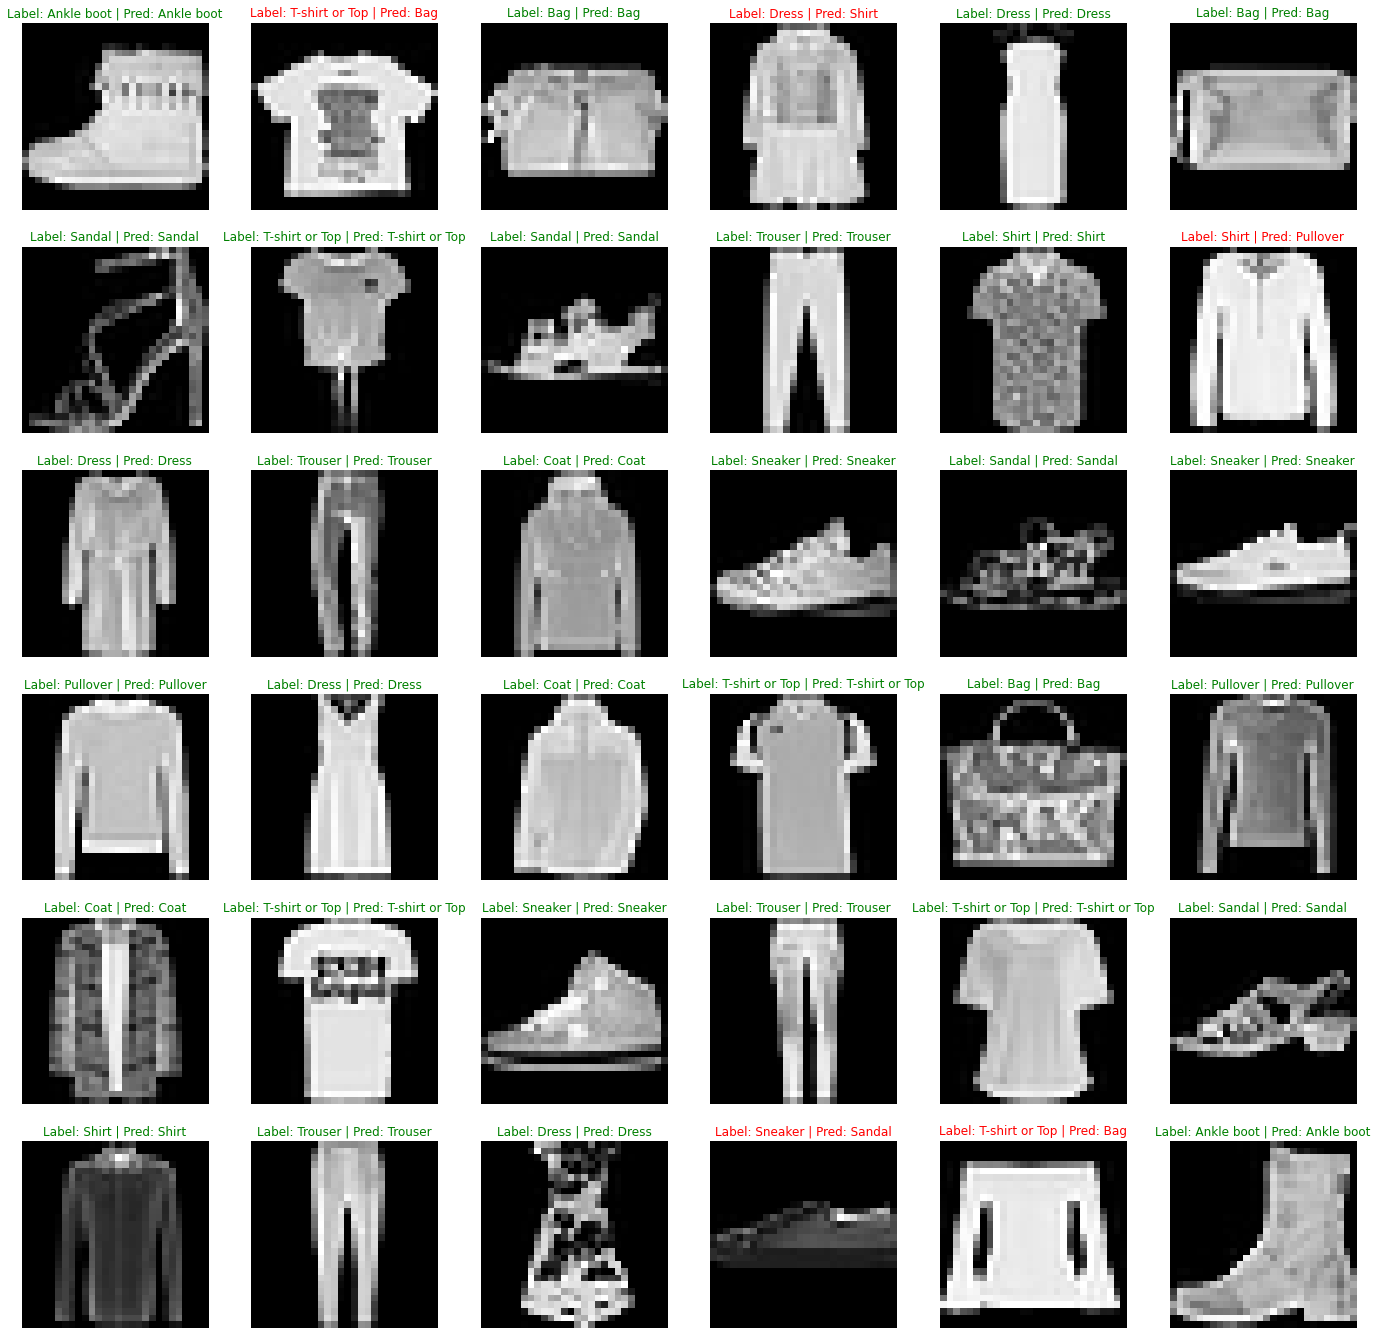

In [20]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {'color': 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()],label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font);
    ax.axis("off");

### From the picture above:

### The red color means the prediction does not match the original<br>
### The green color means it matches the original.

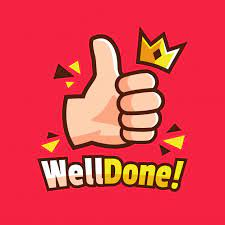

In [12]:
from IPython.display import Image
Image(filename='thumsup.jpg', width=200)